# **HW2**. Сто бед - одна UNet.

Так как по сегментации у нас нет занятия в курсе, а есть только лекции в онлайн-курсе, в этой домашке будут и некоторые вводные по теме, чтобы вы не чувствовали себя брошенными.

Максимум, который можно получить за это дз - **10 баллов**.

## **0. Введение**

Сегментация разная бывает, инстанс мы немножко видели в лекции по детекции, а семантик будет сейчас.

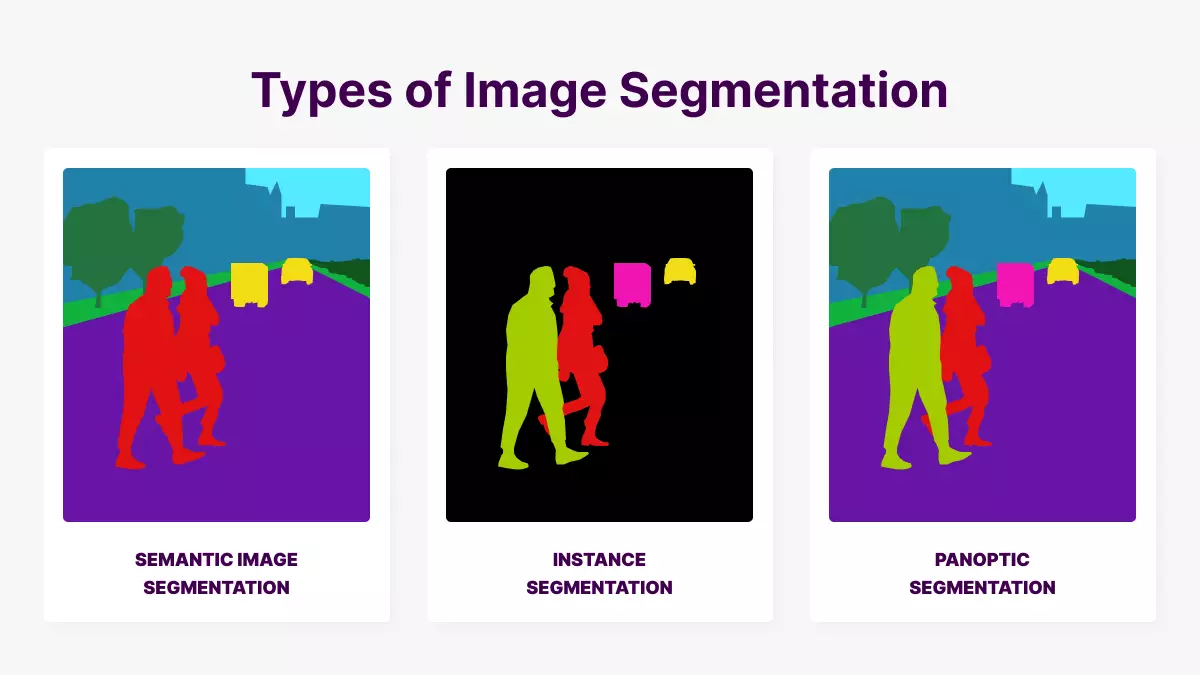

Фактически сегментация - это попиксельная классификация.

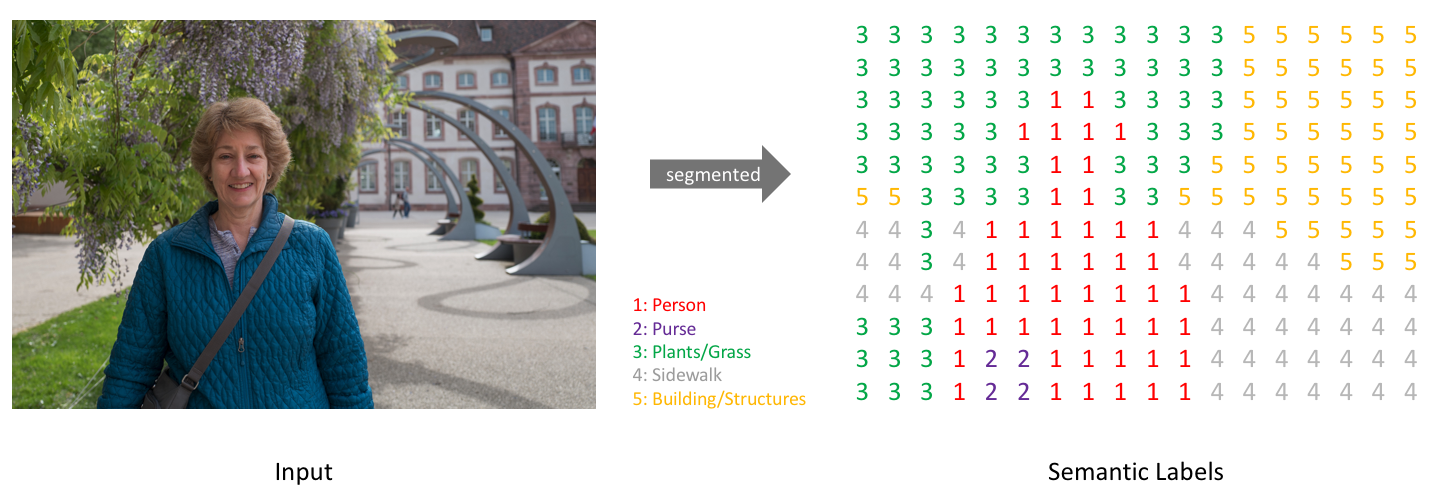

Видео с сегментированными машинками [смотреть тут](https://www.youtube.com/watch?v=ATlcEDSPWXY).

## **1. Подготовь данные**


Будем использовать данные с первого этапа **PicsArt AI Hackathon**. Скачать [тут](https://drive.google.com/file/d/18WuwEMabQVmYB_szumG7PobjuhtpkAVu/view?usp=sharing).
- Загрузим и распакуем данные
- Напишем класс `Dataset` для наших данных
- Посмотрим примеры данных

In [52]:
import os
import cv2

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt


import torchvision
import torch.utils.data as data
import torchvision.models as models
import torchvision.transforms as transforms

import PIL
from PIL import Image
from glob import glob
from torch.utils.data import Dataset, DataLoader

import albumentations as A
import albumentations.pytorch

import warnings
warnings.filterwarnings('ignore')

In [8]:
# from google.colab import drive
# drive.mount("/content/gdrive", force_remount=True)

### **Задание 1** (2 балла)
Для того, чтобы учить сеть, нужен будет `Dataloader`, а значит и собственный `Dataset`. Чтобы собрать `Dataset`, надо понять как выглядят данные и аннотация, а также какие данные понадобятся вашей сетке для обучения.

Данные уже разделены на `train` и `test`, никакого кровосмешения больше не делаем.

**(1 балл)** Разархивируйте данные, загрузите их и визуализируйте фото и соответствующие им маски (4-5 шт). Посмотрите, как устроены маски. Подумайте, как будут соотноситься transform-ы для картинок и масок.

**(1 балл)** Напишите `FaceDataset`, заведите `transform`(ы), заведите по нему loader-ы для трейна и теста, проверьте что всё ок.

In [11]:
# ляля тут надо ваш путь к данным указать
#!unzip -q '/content/gdrive/MyDrive/CV ВШЭ 2024/HW2/data.zip' -d './'

In [53]:
class FaceDataset(Dataset):
    
    def __init__(self, path, transform=None):
        
        img_paths = sorted(glob(os.path.join(path, "*.jpg")))
        mask_paths = []
        
        for image_fn in img_paths:
            mask_fn = image_fn.replace(path, f"{path}_mask").replace("jpg", "png")
            if not os.path.exists(mask_fn):
                raise FileNotFoundError(mask_fn)
            mask_paths.append(mask_fn)
                
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.transform = transform
        
    def __getitem__(self, idx):
        
        # write some code here
        image = cv2.imread(self.img_paths[idx]).astype(np.float32) / 255.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # что хочешь пиши, структуру можно менять как угодно
        
        mask = None
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE) / 255
            
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            
        image = transformed["image"]
        mask = transformed["mask"]
        mask = mask[None, ...]

        return image, mask


    def __len__(self):
        return len(self.img_paths)

In [54]:
transform = A.Compose([
    A.pytorch.transforms.ToTensorV2(transpose_mask=True),
])

In [55]:
train_dataset = FaceDataset("./data/train", transform=transform)
test_dataset = FaceDataset("./data/test", transform=transform)

In [56]:
train_dataset

In [57]:
image, mask = train_dataset[0]

In [58]:
# чекаем что размеры консистентны
image.shape, mask.shape

(torch.Size([3, 320, 240]), torch.Size([1, 320, 240]))

In [60]:
# тут какие то ячейки с визуализациями

In [61]:
def show_image_with_mask(image, mask, predicted=None):
    
    image = (image * 255).astype(np.uint8)
    mask = (mask >= 0.5).astype(np.uint8) * 255
    
    plt.figure(figsize=(20, 8))
    
    plt.subplot(1, 6, 1)
    plt.imshow(image)
    plt.axis(False)

    plt.subplot(1, 6, 2)
    plt.imshow(mask)
    plt.axis(False)

    plt.subplot(1, 6, 3)
    image_masked = cv2.bitwise_and(image, image, mask=mask)
    plt.imshow(image_masked)
    plt.axis(False)

    if predicted is not None:
        predicted = (predicted * 255).astype(np.uint8)
        plt.subplot(1, 6, 4)
        plt.imshow(predicted)
        plt.axis(False)
        
        predicted_binary = (predicted >= 0.5 * 255).astype(np.uint8) * 255
        plt.subplot(1, 6, 5)
        plt.imshow(predicted_binary)
        plt.axis(False)
    
        image_masked = cv2.bitwise_and(image, image, mask=predicted_binary)
        plt.subplot(1, 6, 6)
        plt.imshow(image_masked)
        plt.axis(False)
    
    plt.show()

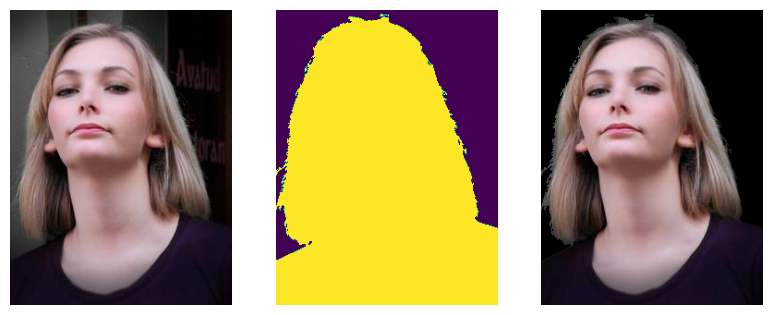

In [74]:
sample = [train_dataset[2]]
sample = [(image.numpy().transpose(1, 2, 0), mask.numpy()[0]) for (image, mask) in sample]

for image, mask in sample:
    show_image_with_mask(image, mask)

## **2. Разберись в U-net**

Как делать можно, но мы так не будем:

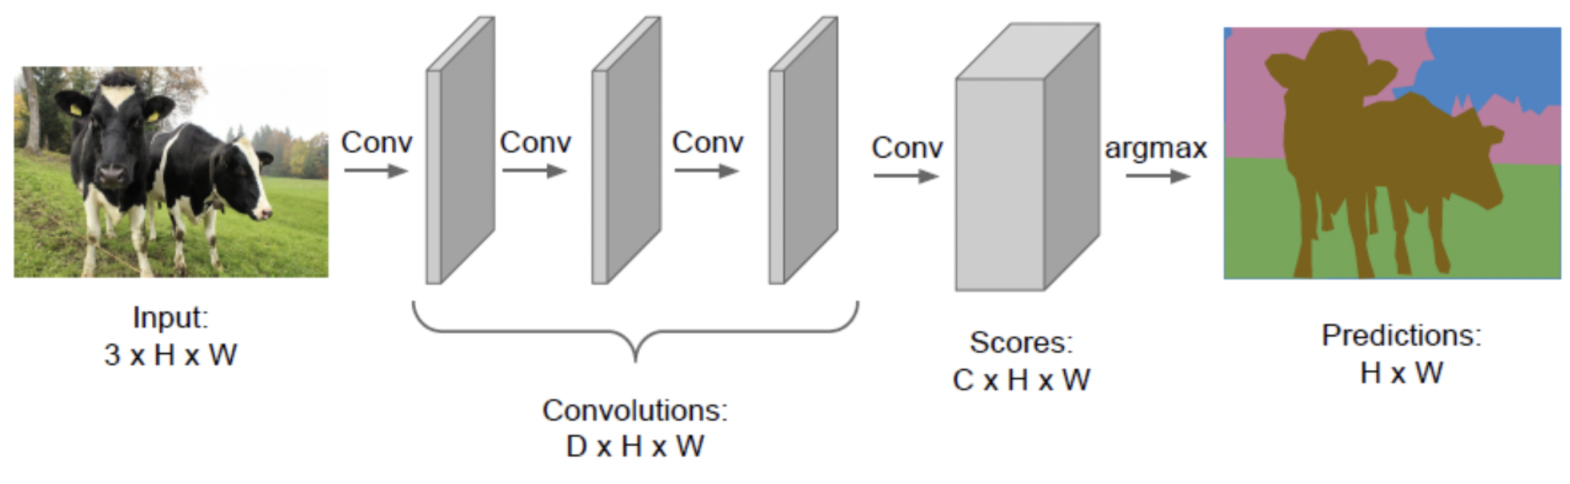

Или так ещё:

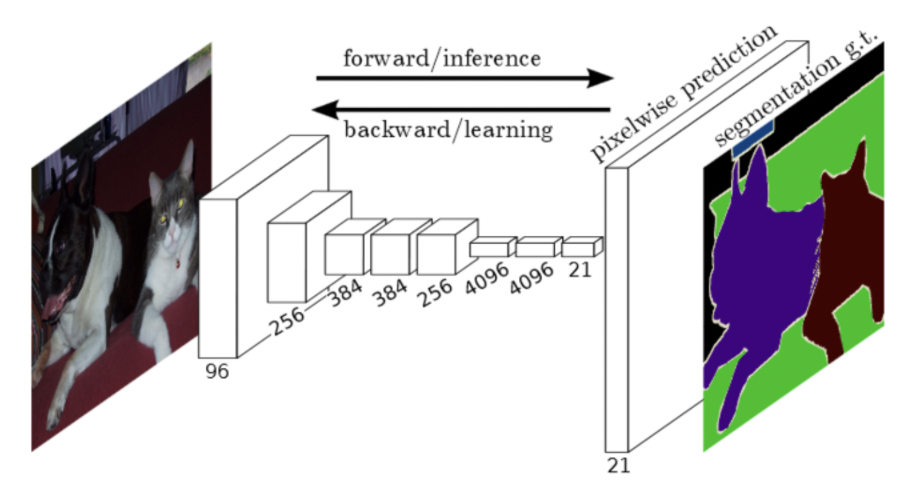

А будем так:

![](https://drive.google.com/uc?export=view&id=1r9oUaZInyoPO9d0pKDt6uOqBgzjZlSy3)

**UNet** - это
- очень сильный бейзлайн для большого спектра задач
- простая идея и реализация

### **Задание 2.** (2 балла)

Пишем энкодер!

Он у нас будет состоять из однообразных блоков, в которых будем только параметризовать количество входных и выходных каналов.

**(1 балл)** Напиши один **блок кодировщика** - он должен состоять из двух последовательных сверток, активаций и опционального батчнорма:

In [75]:
# заведем отдельно себе функцию для светку дальнейшую
def conv3x3(in_channels, out_channels, dilation=1):
    return nn.Conv2d(in_channels, out_channels, 3, padding=dilation, dilation=dilation)

In [76]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, batch_norm=False):
        super().__init__()

        self.batch_norm = batch_norm
        self.conv1 = conv3x3(in_channels, out_channels)

        if self.batch_norm:
            self.bn = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        #self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x):
        # свертка
        # опциональный батч норм
        # активация
        # и повторить

        x = self.conv1(x)

        if self.batch_norm:
            x = self.bn(x)

        x = self.relu(x)
        x = self.conv2(x)

        if self.batch_norm:
            x = self.bn(x)
            
        x = self.relu(x)

        return x

In [77]:
block = EncoderBlock(3, 16)
block

EncoderBlock(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [78]:
x = torch.zeros(4, 3, 128, 128)

with torch.no_grad():
    print(block(x).shape)

torch.Size([4, 16, 128, 128])


**(1 балл)** А теперь напишем класс для всего энкодера.

Его конструкция определяется числом входных каналов, количеством фильтров в первом блоке и количеством блоков.

Помним также, что для работы сети нам нужно запоминать промежуточные активации. (Их будем по skip connection-ам ещё кидать).

In [ ]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_filters, num_blocks):
        super().__init__()

        self.num_blocks = num_blocks

        # пройдем по блокам и посчитаем какие в каждом будут in и out channels
        # советую посмотреть на схему архитектуры
        # вход-выход последовательных должны очевидно совпадать
        # а количество выходных должно по степени двойки возрастать
        for i in range(num_blocks):
            in_channels = num_filters * 2**i
            out_channels = #

            self.add_module(f'block{i + 1}', EncoderBlock(in_channels, out_channels))
            if i != num_blocks - 1:
                self.add_module(f'pool{i + 1}', nn.MaxPool2d(2, 2))

    def forward(self, x):
        acts = [] # нам некоторые выходы ещё понадобятся, будем их собирать

        for i in range(self.num_blocks):
            x = self.__getattr__(f"block{i+1}")(x) # вызываем блок, берем его результат
            acts.append(x) # кладем результирующую feature map

            if i != self.num_blocks - 1: # если это не последний блок, то дропаем пространственную размерность
              x = self.__getattr__(f"pool{i+1}")(x)
        return acts

In [ ]:
# проверяем что всё ок
encoder = Encoder(in_channels=3, num_filters=16, num_blocks=4)
encoder

In [ ]:
# проверяем что всё ок
x = torch.zeros(4, 3, 512, 512)

[_.shape for _ in encoder(x)]

### **Задание 3.** (2 балла)

Пишем декодер!

Блок декодера состоит из `transposed convolutions` c учетом `skip connections`: апскейлинга входа "снизу" + свертки, конкатенации `feature map` с одного уровня энкодера и декодера и их совместное сворачивание.

Есть несколько способов повысить разрешение тензора - например это разные типы интерполяции: `nearest neighbour`, `bilinear`, `bicubic`.

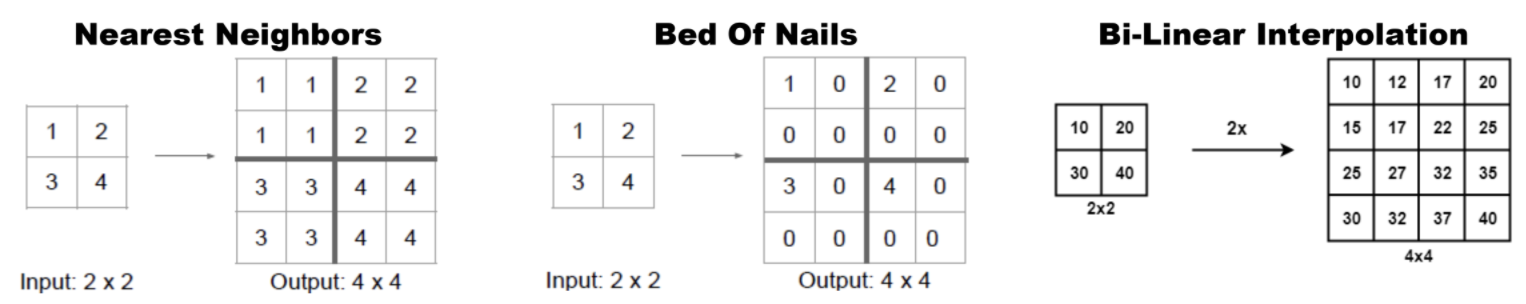

![](https://drive.google.com/uc?export=view&id=1Sazg6ZRQmw8xrJg4-MMccO0S_ib3kjvn)

В `pytorch` это можно делать с помощью модуля: [`nn.Upsample`](https://pytorch.org/docs/stable/generated/torch.nn.Upsample.html) + `nn.conv2d`, а можно использовать сразу [`nn.ConvTranspose2d`](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html).

В типичном репозитории `UNet` например есть [опция](https://github.com/milesial/Pytorch-UNet/blob/8f317cb13c17ef25a86b25a0c24390e04cd4db82/unet/unet_parts.py#L50) что делать.


**(1 балл)** Напиши блок декодера.

In [ ]:
class DecoderBlock(nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.uppool = #
        self.upconv = #
        self.conv1 = #
        self.conv2 = #

    def forward(self, down, left):
        x = self.uppool(down)
        x = self.upconv(x)
        x = # тут сконкатенируй наш тензор, и тот что пришел слева

        x = self.conv1(x)
        x = self.conv2(x)
        return x

**(1 балл)** Собери весь декодер из блочков.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        # собираем блоки в обратном порядке
        for i in range(num_blocks):
            self.add_module(f'block{num_blocks - i}', DecoderBlock(#а что тут?))

    def forward(self, acts):
        up = # сперва берем последнюю в списке фичемапу как есть

        # далее начинаем их конкатенировать и прогонять через блоки
        for i, left in enumerate(acts[-2::-1]):
            up = self.__getattr__(f'block{i + 1}')(up, left)
        return up

In [ ]:
[_.shape for _ in encoder(x)]

In [ ]:
# проверяем что всё ок
decoder = Decoder(16, 3)
decoder

In [ ]:
# проверяем что всё ок
decoder(encoder(x)).shape

`U-Net` состоит из такого кодировщика и декодировщика, а также финального слоя классификации:

In [ ]:
class UNet(nn.Module):
    def __init__(self, num_classes, in_channels=3, num_filters=16, num_blocks=4):
        super().__init__()

        self.encoder = Encoder(in_channels, num_filters, num_blocks)
        self.decoder = Decoder(num_filters, num_blocks-1)
        self.final = nn.Conv2d(num_filters, num_classes, 1)

    def forward(self, x):
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)
        return x

In [ ]:
model = UNet(num_classes=1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

In [ ]:
# проверяем что всё ок
images = torch.randn(4, 3, 416, 416).to(device)

model(images).shape

## **3. Обучи сеть**



Ну а теперь будем учить.

### Вспомогательные функции

In [ ]:
# функция для обучения, используй на свое усмотрение
def train_epoch(model, optimizer, train_loader, criterion, device):
    model.train()

    for batch_train, batch_answers in train_loader:
        batch_train = batch_train.to(device)
        batch_answers = batch_answers.to(device)

        optimizer.zero_grad()

        model_answers = model(batch_train)

        new_loss = criterion(model_answers, batch_answers)
        new_loss.backward()
        optimizer.step()

Какую метрику использовать для оценки качества сегментации?
Можно IoU, а можно Dice.

В целом он очень близок к IoU, но в знаменателе полная сумма, а не объединение (поэтому числитель и удвоен, тк в знаменателе он тоже дважды учитывается).

А крут он тем, что из него можно сделать дифференцируемую функцию и свести задачу сразу к оптимизации целевой метрики.

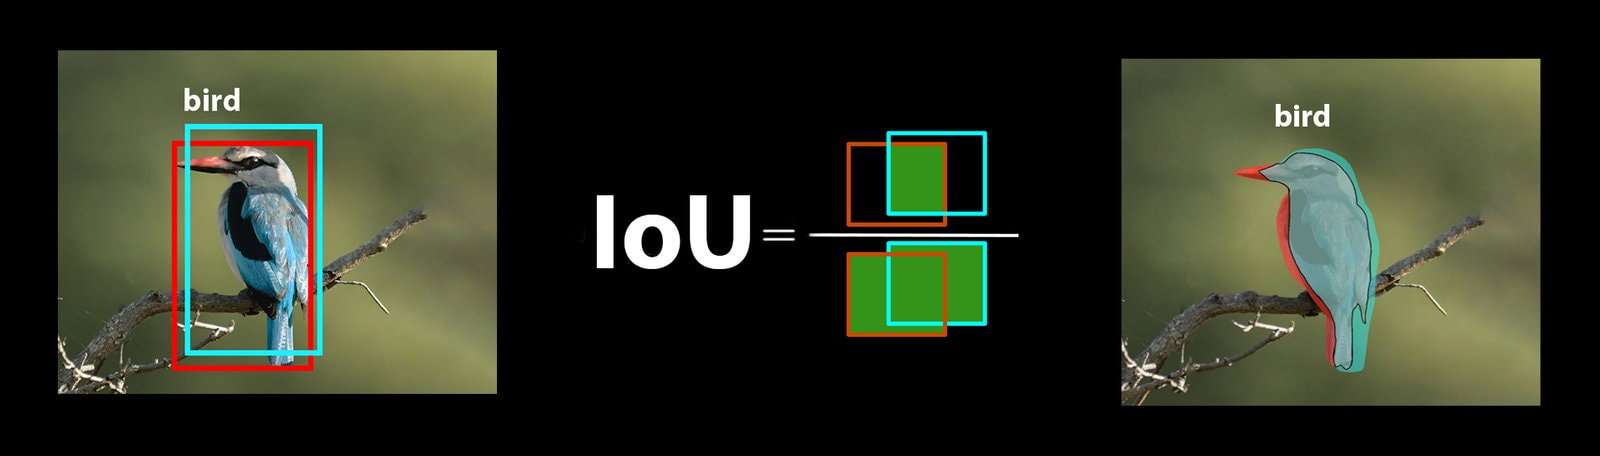

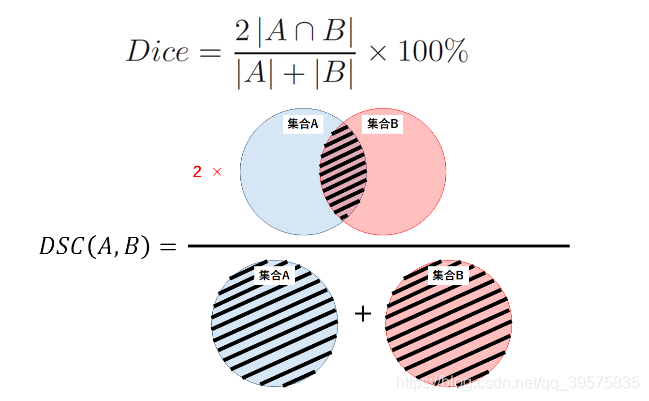

In [ ]:
def dice_score(pred_mask, true_mask):
    smooth = 1e-10
    true_mask = true_mask.astype(bool)
    pred_mask = pred_mask.astype(bool)

    intersection = (true_mask & pred_mask).sum()
    im_sum = true_mask.sum() + pred_mask.sum()

    return 2. * intersection / (im_sum + smooth)

In [ ]:
# функция для тестирования, меняй по своему усмотрению
def evaluate_loss(loader, model, criterion, th, device):
    model.eval()

    total_loss = 0
    total_dice = 0
    total_n = 0

    with torch.no_grad():
        for batch_test, batch_answers in loader:
            batch_test = batch_test.to(device)
            batch_answers = batch_answers.to(device)

            model_answers = torch.sigmoid(model(batch_test))
            one_batch_loss = float(criterion(model_answers, batch_answers))

            # отсекаем неуверенные точки маски, по уверенным считаем dice
            model_mask = model_answers > th
            one_batch_dice = float(dice_score(model_mask.cpu().numpy(), batch_answers.cpu().numpy()))

            total_loss += one_batch_loss
            total_dice += one_batch_dice
            total_n += 1

    return (total_loss / total_n, total_dice / total_n)

### **Задание 4**. (2 балла)

А теперь эксперимент.

**(1 балл)** Собери все части вместе, обучи сетку, отрисуй свои результаты

**(1 балл)** Получи avg test dice score = 0.9.

In [ ]:
# создаем лоадеры для данных
batch_size = #
train_loader = #
test_loader = #

In [ ]:
# готовим всё важное: модель, оптимайзер, лосс
model = UNet(num_classes=1)
lr = #
epochs = #
optimizer = #
criterion = nn.BCEWithLogitsLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
th  # порог на скор предсказанной маски

In [ ]:
# main loop!

for epoch in range(1, epochs):
    train_epoch(model, optimizer, train_loader, criterion, device=0)
    train_loss, train_dice = evaluate_loss(train_loader, model, criterion, th=th, device=0)
    test_loss, test_dice = evaluate_loss(test_loader, model, criterion, th=th, device=0)

    preds = torch.sigmoid(model(images.to(0))).cpu().detach()
    print(f'Epoch {epoch}: avg train loss {train_loss:.04f}, avg train dice score {train_dice:.04f}')
    print(f'Avg test loss {test_loss:.04f}, avg test dice score {test_dice:.04f}')
    print('________________')

In [ ]:
# отрисуй несколько картинок из теста, их gt маски и предсказания

## **4. Сделай лучше**

### **Задание 5**. (2 балла)

Мы уже молодцы, но можно лучше. Осталась последняя часть - получить на тесте реально хорошие метрики.

**(1 балл)** Получи avg test dice score = 0.93.

**(1 балл)** Получи avg test dice score = 0.96.

**Во что потыкать при обучении:**
- Количество блоков
- Использовать **Dice Loss** для обучения
- Аугментации, препроцессинг
- Модифицировать исходные маски (например, убрать артефакты на границе с помощью фильтра)
- Постпроцессинг (порог для маски, постобработка маски - например, заполнить дыры)
- Во всё, что мы обсуждали по трюкам на занятии 2

In [ ]:
# вот эту версию можно использовать в качестве loss-а
def dice_loss(pred_tensor, target_tensor):
    smooth = 1.

    iflat = pred_tensor.contiguous().view(-1)
    tflat = target_tensor.contiguous().view(-1)
    intersection = (iflat * tflat).sum()

    A_sum = torch.sum(iflat)
    B_sum = torch.sum(tflat)

    return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth))

### **GL, HF!**